# Enterprise Computational Infrastructure Simulation Project
## Cuantitative Methods, Spring 2017
## Tec de Monterrey, campus Monterrey

Marco A. Peyrot (A00815262)

Oliver D. Mendoza (A00513632)

Juan Carlos Guzmán (A01175826)

In [1]:
# the libraries required to anaylze the data
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import plotly.plotly as py
import plotly.tools as tls
from plotly.graph_objs import *
import plotly.tools as tls
import seaborn as sns
import matplotlib.patches as mpatches
import math
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn import linear_model
from scipy.stats import norm, exponweib, lognorm

# dynamic plotting information
py.plotly.tools.set_credentials_file(username='mpeyrotc', api_key='pNScWhvJN9woL3frF4Vd')
%matplotlib inline

# Part A) Statistical Analysis

## Principal Components Selection (Cause-Effect)

Starting from the data provided by the course staff about the performance measures for the servers we transferred the data into python through the Pandas library. We take care of cleaning up the data by eliminating null rows and
and transforming the time column to a more friendly numeric format.

In [2]:
# Open excel file
R3P = pd.ExcelFile("R3P Q2 Mayo (ADV).xlsx")
# Open a specific spreadsheet
R3P_1 = R3P.parse("R3P Q2 Mayo")

R3P_1 = R3P_1.ix[4:,3:31]

R3P_1.columns=['Weekday', 'Time', 'Act. WPs', 'Dia.WPs', 'RFC WPs', 'CPU Usr',
            'CPU Sys', 'CPU Idle', 'Paging in', 'Paging out', 'Free Mem.', 
            'EM alloc.', 'EM attach.', 'Em global', 'Heap Memor', 'Private Modes',
            'Paging Mem', 'Roll Mem', 'Logins', 'Sessions', '# Pasos Dialogo',
            'Resp. Time (Total)', 'CPU (Total)', 'CPU (Prom)', 'BD (Total)', 
            'BD (Prom)', 'Response Time (Prom)', 'Label']

# Clean and reformat data
R3P_1.dropna(how="all", inplace=True)
R3P_1['Time'] = R3P_1['Time'].astype(str).apply(lambda x: str(x[0]) + str(x[1]))

X = R3P_1.ix[:,0:-1]
X = X.apply(pd.to_numeric, errors='coerce')

X = X.values

Once we have loaded the data, we proceed to do PCA (Principal component analysis). We get the contribution that each component provides.

In [3]:
X_std = StandardScaler().fit_transform(X)
cov_mat = np.cov(X_std.T)
eig_vals, eig_vecs = np.linalg.eig(cov_mat)

In [4]:
# Check that the probability contribution of all eigen vectors gives 1.
for ev in eig_vecs:
    np.testing.assert_array_almost_equal(1.0, np.linalg.norm(ev))
    
print('Everything ok!')

Everything ok!


In [5]:
# Make a list of (eigenvalue, eigenvector) tuples
eig_pairs = [(np.abs(eig_vals[i]), eig_vecs[:,i]) for i in range(len(eig_vals))]

# Sort the (eigenvalue, eigenvector) tuples from high to low
eig_pairs.sort(key=lambda x: x[0], reverse=True)

In [6]:
# make cumulative line to visualiza better their contributions
tot = sum(eig_vals)
var_exp = [(i / tot)*100 for i in sorted(eig_vals, reverse=True)]
cum_var_exp = np.cumsum(var_exp)

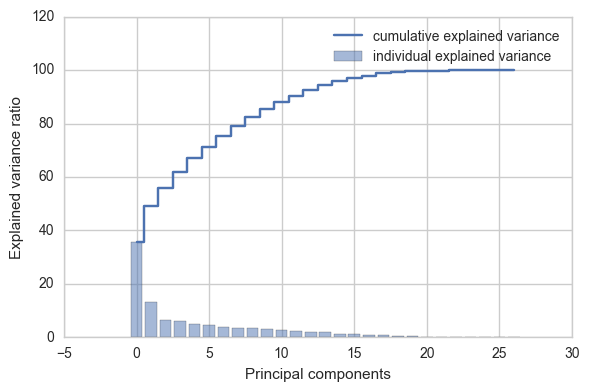

In [7]:
with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(6, 4))

    plt.bar(range(27), var_exp, alpha=0.5, align='center',
            label='individual explained variance')
    plt.step(range(27), cum_var_exp, where='mid',
             label='cumulative explained variance')
    plt.ylabel('Explained variance ratio')
    plt.xlabel('Principal components')
    plt.legend(loc='best')
    plt.tight_layout()
    plt.show()

## PCA Analysis

With the results provided by the previous analysis we determined that the first 3 components contribute the most to the actual values. We use biplots to determine correlations between the variables we have. In order to get the PCA analysis for the bibplots we used XLSTAT and loaded the results for F1 and F2 components.

In [8]:
PCAs = pd.ExcelFile("PCAs.xlsx")
F1F2 = PCAs.parse("F1F2")

F1F2_X = F1F2.ix[104:130,1:28]

columns = []
for i in xrange(0,27):
    columns.append("F" + str(i + 1))

F1F2_X.columns=columns

F1F2_y = F1F2.ix[104:130,0:1]

### Components F1 and F2

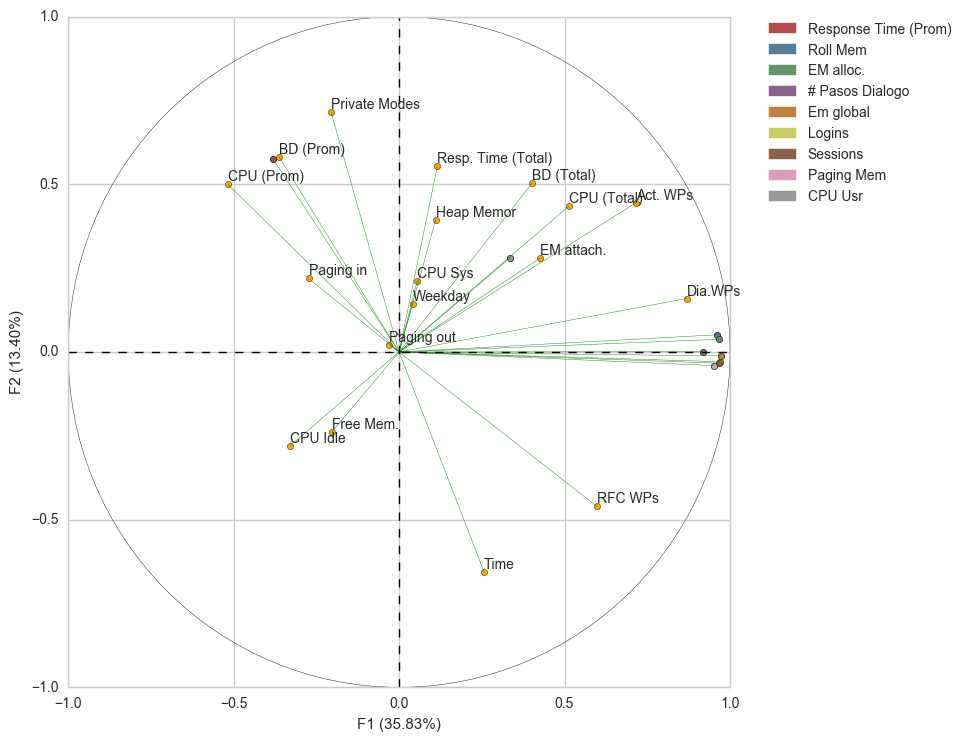

In [9]:
with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(7.5, 7.5))
    plt.scatter(F1F2_X.T.values[0], F1F2_X.T.values[1], c="Orange")
    plt.ylabel('F2 (13.40%)')
    plt.xlabel('F1 (35.83%)')
    plt.tight_layout()
    axes = plt.gca()
    axes.set_xlim([-1,1])
    axes.set_ylim([-1,1])
    
    discriminators = [26, 17, 11, 20, 13, 18, 19, 16, 5]
    colors = sns.color_palette("Set1", n_colors=len(discriminators), desat=.5)
    
    for x,y,closest,label in zip(F1F2_X.T.values[0], F1F2_X.T.values[1], range(0,27), F1F2_y.T.values[0]):
        plt.plot([0,x], [0, y], '-', linewidth=0.3, c="Green")
        if closest not in  discriminators:
            plt.annotate(label, xy=(x, y), xytext=(x, y + 0.01))

    legend = []
    for index, color in zip(discriminators, colors.as_hex()):
        plt.scatter(F1F2_X.T.values[0][index], F1F2_X.T.values[1][index], c=color)
        legend.append(mpatches.Patch(color=color, label=F1F2_y.T.values[0][index]))
        
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., handles=legend)
    
    plt.plot([-1, 1], [0, 0], '--', linewidth=1, c="Black")
    plt.plot([0, 0], [-1, 1], '--', linewidth=1, c="Black")
    circle = plt.Circle((0, 0), 1, color='Black', fill=False)
    plt.gcf().gca().add_artist(circle)
    
    plt.show()

### Components F1 and F3

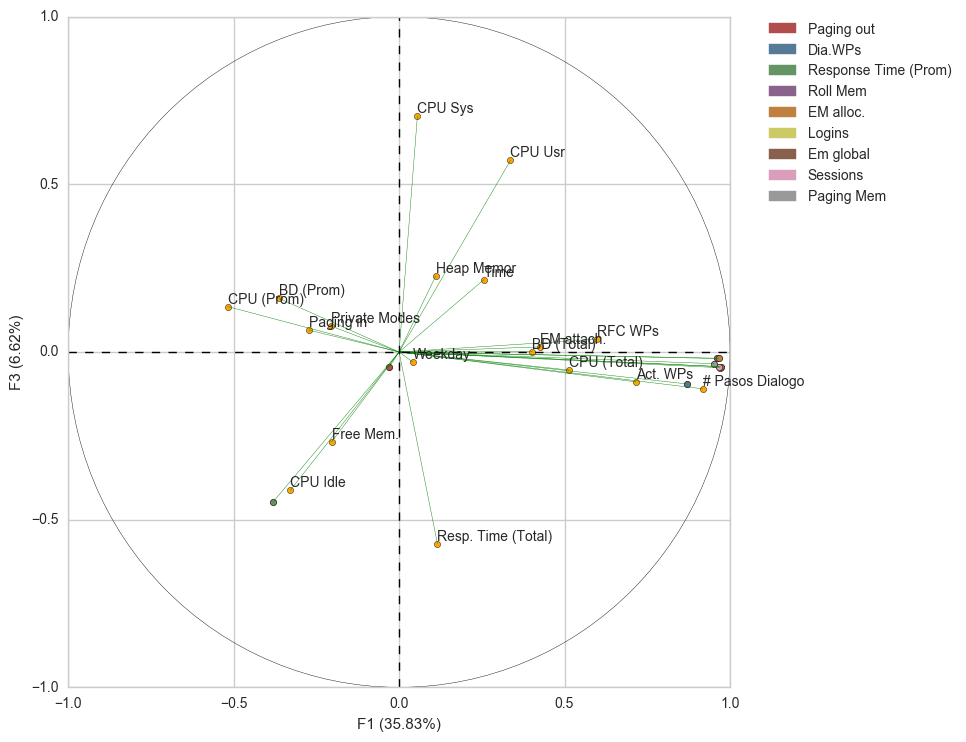

In [10]:
with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(7.5, 7.5))
    
    plt.scatter(F1F2_X.T.values[0], F1F2_X.T.values[2], c="Orange")
    plt.ylabel('F3 (6.62%)')
    plt.xlabel('F1 (35.83%)')
    plt.tight_layout()
    axes = plt.gca()
    axes.set_xlim([-1,1])
    axes.set_ylim([-1,1])
    
    discriminators = [9, 3, 26, 17, 11, 18, 13, 19, 16]
    colors = sns.color_palette("Set1", n_colors=len(discriminators), desat=.5)
    
    for x,y,closest,label in zip(F1F2_X.T.values[0], F1F2_X.T.values[2], range(0,27), F1F2_y.T.values[0]):
        plt.plot([0,x], [0, y], '-', linewidth=0.3, c="Green")
        if closest not in  discriminators:
            plt.annotate(label, xy=(x, y), xytext=(x, y + 0.01))
            
    legend = []
    for index, color in zip(discriminators, colors.as_hex()):
        plt.scatter(F1F2_X.T.values[0][index], F1F2_X.T.values[2][index], c=color)
        legend.append(mpatches.Patch(color=color, label=F1F2_y.T.values[0][index]))
        
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., handles=legend)
    
    plt.plot([-1, 1], [0, 0], '--', linewidth=1, c="Black")
    plt.plot([0, 0], [-1, 1], '--', linewidth=1, c="Black")
    circle = plt.Circle((0, 0), 1, color='Black', fill=False)
    plt.gcf().gca().add_artist(circle)
    
    plt.show()

### Components F2 and F3

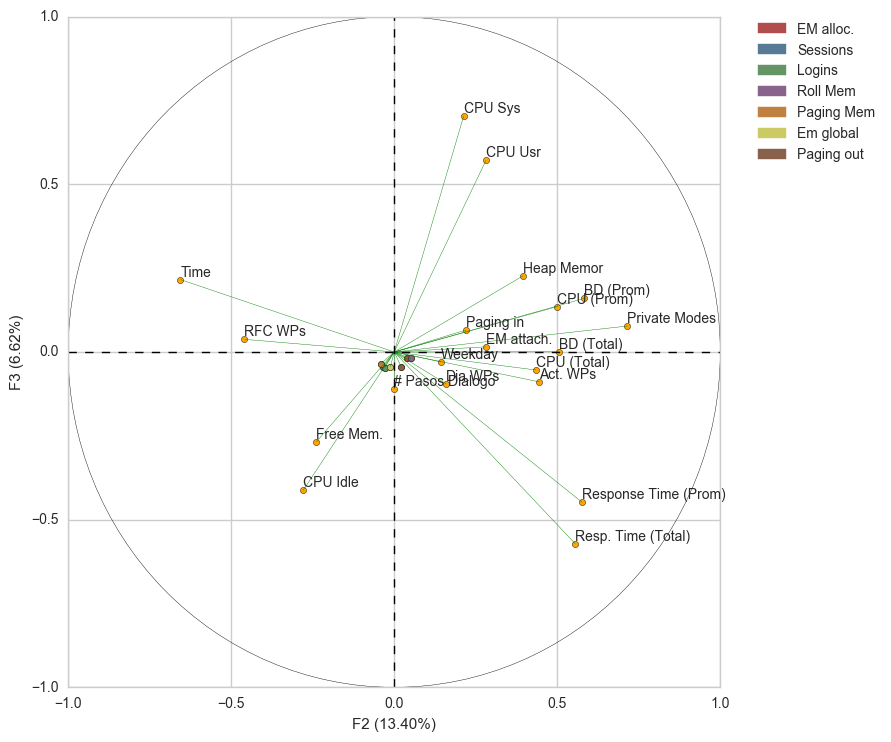

In [11]:
with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(7.5, 7.5))
    plt.scatter(F1F2_X.T.values[1], F1F2_X.T.values[2], c="Orange")
    plt.ylabel('F3 (6.62%)')
    plt.xlabel('F2 (13.40%)')
    plt.tight_layout()
    axes = plt.gca()
    axes.set_xlim([-1,1])
    axes.set_ylim([-1,1])
    
    discriminators = [11, 19, 18, 17, 16, 13, 9]
    colors = sns.color_palette("Set1", n_colors=len(discriminators), desat=.5)
    
    for x,y,closest,label in zip(F1F2_X.T.values[1], F1F2_X.T.values[2], range(0,27), F1F2_y.T.values[0]):
        plt.plot([0,x], [0, y], '-', linewidth=0.3, c="Green")
        if closest not in  discriminators:
            plt.annotate(label, xy=(x, y), xytext=(x, y + 0.01))
            
    legend = []
    for index, color in zip(discriminators, colors.as_hex()):
        plt.scatter(F1F2_X.T.values[1][index], F1F2_X.T.values[2][index], c=color)
        legend.append(mpatches.Patch(color=color, label=F1F2_y.T.values[0][index]))
        
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., handles=legend)
    
    plt.plot([-1, 1], [0, 0], '--', linewidth=1, c="Black")
    plt.plot([0, 0], [-1, 1], '--', linewidth=1, c="Black")
    circle = plt.Circle((0, 0), 1, color='Black', fill=False)
    plt.gcf().gca().add_artist(circle)

    plt.tight_layout()
    
    plt.show()

# Critical variables selection and dimension reduction

Based on the obtained biplots we determined that the following variables are correlated to response time (average) our objective. According to the principal components F1 and F2, relevant variables are:

1. BD (Prom)
2. CPU(Prom)
3. Private modes
4. RFC WPs
5. Time

In the same way, using components F1 and F3 the following variables are also related to response time (average):

6. CPU Idle
7. CPU Usr

Next we show the behavior graphs for each one of these variables in relation to response time. The Orange graphs represent the ones with a visible relation between them.

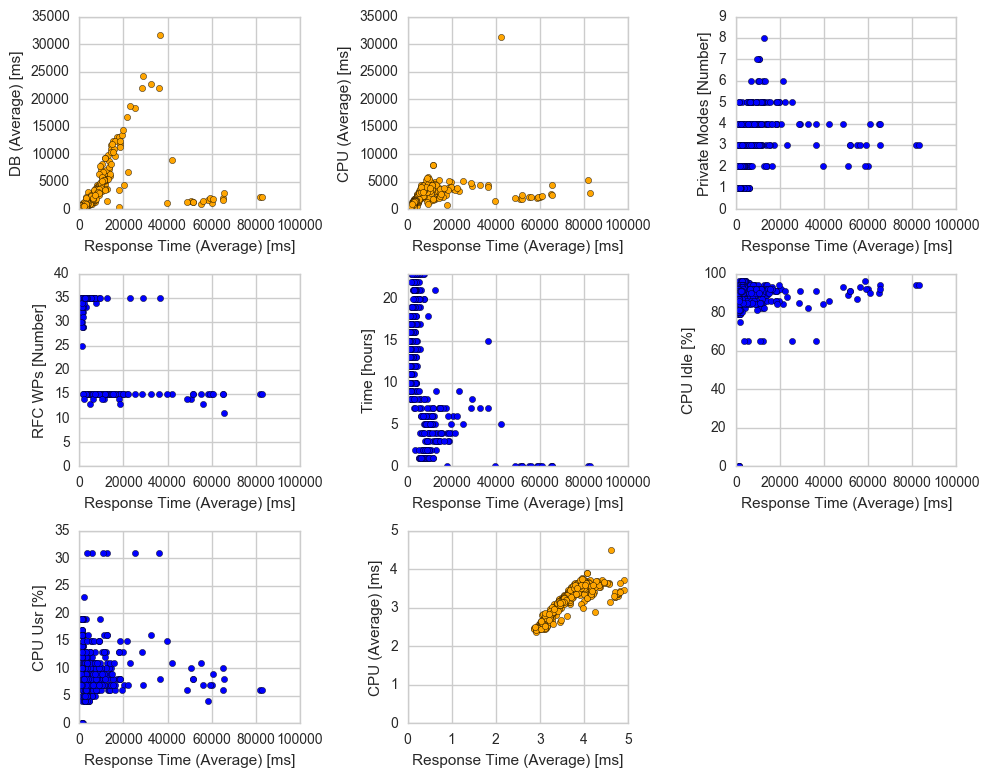

In [12]:
with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(10, 10))
    
    plt.subplot(4, 3, 1)
    axes = plt.gca()
    axes.set_xlim([0,100000])
    axes.set_ylim([0,35000])
    plt.scatter(R3P_1["Response Time (Prom)"].T, R3P_1["BD (Prom)"].T, c="Orange")
    plt.xlabel('Response Time (Average) [ms]')
    plt.ylabel('DB (Average) [ms]')
    
    plt.subplot(4, 3, 2)
    axes = plt.gca()
    axes.set_xlim([0,100000])
    axes.set_ylim([0,35000])
    plt.scatter(R3P_1["Response Time (Prom)"].T, R3P_1["CPU (Prom)"].T, c="Orange")
    plt.xlabel('Response Time (Average) [ms]')
    plt.ylabel('CPU (Average) [ms]')
    
    plt.subplot(4, 3, 3)
    axes = plt.gca()
    axes.set_xlim([0,100000])
    axes.set_ylim([0,9])
    plt.scatter(R3P_1["Response Time (Prom)"].T, R3P_1["Private Modes"].T, c="Blue")
    plt.xlabel('Response Time (Average) [ms]')
    plt.ylabel('Private Modes [Number]')
    
    plt.subplot(4, 3, 4)
    axes = plt.gca()
    axes.set_xlim([0,100000])
    axes.set_ylim([0,40])
    plt.scatter(R3P_1["Response Time (Prom)"].T, R3P_1["RFC WPs"].T, c="Blue")
    plt.xlabel('Response Time (Average) [ms]')
    plt.ylabel('RFC WPs [Number]')
    
    plt.subplot(4, 3, 5)
    axes = plt.gca()
    axes.set_xlim([0,100000])
    axes.set_ylim([0,23])
    plt.scatter(R3P_1["Response Time (Prom)"].T, R3P_1["Time"].T, c="Blue")
    plt.xlabel('Response Time (Average) [ms]')
    plt.ylabel('Time [hours]')
    
    plt.subplot(4, 3, 6)
    axes = plt.gca()
    axes.set_xlim([0,100000])
    axes.set_ylim([0,100])
    plt.scatter(R3P_1["Response Time (Prom)"].T, R3P_1["CPU Idle"].T, c="Blue")
    plt.xlabel('Response Time (Average) [ms]')
    plt.ylabel('CPU Idle [%]')
    
    plt.subplot(4, 3, 7)
    axes = plt.gca()
    axes.set_xlim([0,100000])
    axes.set_ylim([0,35])
    plt.scatter(R3P_1["Response Time (Prom)"].T, R3P_1["CPU Usr"].T, c="Blue")
    plt.xlabel('Response Time (Average) [ms]')
    plt.ylabel('CPU Usr [%]')
    
    response_time = R3P_1["Response Time (Prom)"].apply(math.log10)
    cpu_prom = R3P_1["CPU (Prom)"].apply(math.log10)
    
    plt.subplot(4, 3, 8)
    axes = plt.gca()
    axes.set_xlim([0,5])
    axes.set_ylim([0,5])
    plt.scatter(response_time.T, cpu_prom.T, c="Orange")
    plt.xlabel('Response Time (Average) [ms]')
    plt.ylabel('CPU (Average) [ms]')
    
    plt.tight_layout()
    plt.show()

The last one was done in a log scale to produce a more precise relation between them. These graphs clearly show a relation between DB (Prom) y CPU(Prom) as potential variables to improve the system performance. We propose mathematical functions which are representative of the system behavior.

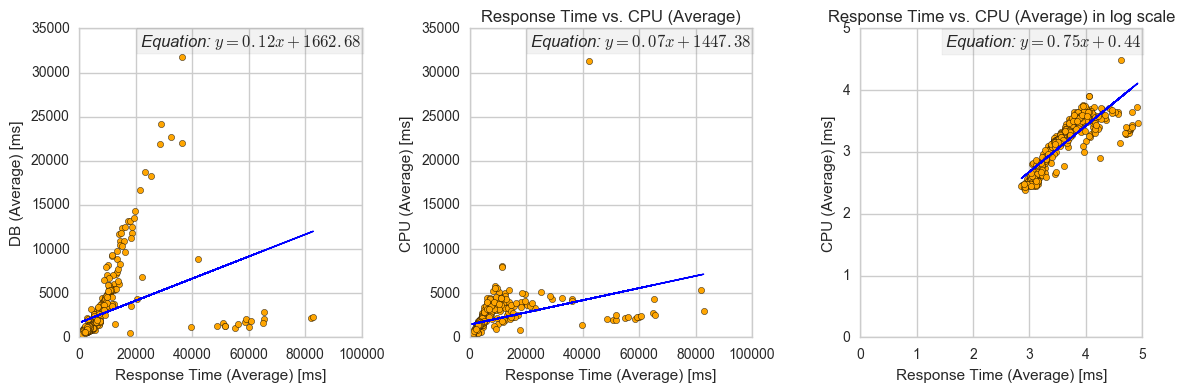

In [13]:
with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(12, 4))
    
    x = R3P_1.loc[:,"Response Time (Prom)"][:, np.newaxis]
    y = R3P_1.loc[:,"BD (Prom)"]
    
    regr = linear_model.LinearRegression()
    regr.fit(x, y)
    
    plt.subplot(1, 3, 1)
    axes = plt.gca()
    axes.set_xlim([0,100000])
    axes.set_ylim([0,35000])
    plt.scatter(R3P_1["Response Time (Prom)"].T, R3P_1["BD (Prom)"].T, c="Orange")
    plt.xlabel('Response Time (Average) [ms]')
    plt.ylabel('DB (Average) [ms]')
    plt.plot(x, regr.predict(x), color='blue', linewidth=1)
    
    plt.text(21500, 33000, r'Equation: $y={coef}x+{intercept}$'.format(coef="{0:.2f}".format(regr.coef_[0]), 
            intercept="{0:.2f}".format(regr.intercept_)), fontsize=12, style='italic', 
             bbox={'facecolor':'gray', 'alpha':0.1, 'pad':2})

    x = R3P_1.loc[:,"Response Time (Prom)"][:, np.newaxis]
    y = R3P_1.loc[:,"CPU (Prom)"]

    regr = linear_model.LinearRegression()
    regr.fit(x, y)

    plt.subplot(1, 3, 2)
    axes = plt.gca()
    axes.set_xlim([0,100000])
    axes.set_ylim([0,35000])
    plt.scatter(R3P_1["Response Time (Prom)"].T, R3P_1["CPU (Prom)"].T, c="Orange")
    plt.xlabel('Response Time (Average) [ms]')
    plt.ylabel('CPU (Average) [ms]')
    plt.plot(x, regr.predict(x), color='blue', linewidth=1)
    plt.text(21300, 33000, r'Equation: $y={coef}x+{intercept}$'.format(coef="{0:.2f}".format(regr.coef_[0]), 
                                                                       intercept="{0:.2f}".format(regr.intercept_)),
             fontsize=12, style='italic', bbox={'facecolor':'gray', 'alpha':0.1, 'pad':2})
    plt.title("Response Time vs. CPU (Average)")
    
    x = response_time[:, np.newaxis]
    y = cpu_prom

    regr = linear_model.LinearRegression()
    regr.fit(x, y)

    plt.subplot(1, 3, 3)
    axes = plt.gca()
    axes.set_xlim([0,5])
    axes.set_ylim([0,5])
    plt.scatter(response_time.T, cpu_prom.T, c="Orange")
    plt.xlabel('Response Time (Average) [ms]')
    plt.ylabel('CPU (Average) [ms]')
    plt.plot(x, regr.predict(x), color='blue', linewidth=1)
    plt.text(1.5, 4.7, r'Equation: $y={coef}x+{intercept}$'.format(coef="{0:.2f}".format(regr.coef_[0]), 
                                                                       intercept="{0:.2f}".format(regr.intercept_)),
             fontsize=12, style='italic', bbox={'facecolor':'gray', 'alpha':0.1, 'pad':2})
    plt.title("Response Time vs. CPU (Average) in log scale")
    
    plt.tight_layout()
    plt.show()

Sadly for this data the outliers drastically affect the fitting of a general equation. However this is not the case for the CPU average. However, to do a more thorough analysis, we fitted several different trendlines to the data, and the best results yielded were the following:

![CPU](CPU trendline.png)
![BD](DB trendline.png)

## Statistic analysis

Because we found not one, but two critical variables (BD and CPU), we will analyze both, to see which one is more reliable. We will measure its mean, varianza, standard deviation, symetry and kurtosis for each variable.

In [14]:
print("CPU (Prom):\n")
print "Mean:\t\t\t", R3P_1["CPU (Prom)"].mean()
print "Variance:\t\t", R3P_1["CPU (Prom)"].var()
print "Standard deviation:\t", R3P_1["CPU (Prom)"].std()
print "Symetry:\t\t", R3P_1["CPU (Prom)"].skew()
print "Kurtosis:\t\t", R3P_1["CPU (Prom)"].kurtosis()
print
print("BD (Prom):\n")
print "Mean:\t\t\t", R3P_1["BD (Prom)"].mean()
print "Variance:\t\t", R3P_1["BD (Prom)"].var()
print "Standard deviation:\t", R3P_1["BD (Prom)"].std()
print "Symetry:\t\t", R3P_1["BD (Prom)"].skew()
print "Kurtosis:\t\t", R3P_1["BD (Prom)"].kurtosis()

CPU (Prom):

Mean:			1972.3754902
Variance:		4291461.91424
Standard deviation:	2071.58439708
Symetry:		7.28690287156
Kurtosis:		98.3050932754

BD (Prom):

Mean:			2615.78504902
Variance:		15188169.9231
Standard deviation:	3897.20026726
Symetry:		3.47968529158
Kurtosis:		15.3860227278


It can be easily seen that both variables have a heavy tail, since kurtosis is greater than 3. You can see the histogram of the variables below.

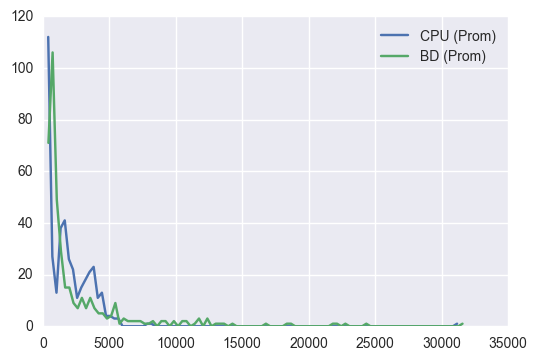

In [15]:
import numpy as np
import pylab as p

data=R3P_1["CPU (Prom)"]
y,binEdges=np.histogram(data,bins=100)
bincenters = 0.5*(binEdges[1:]+binEdges[:-1])
p.plot(bincenters,y,'-', label="CPU (Prom)")

data=R3P_1["BD (Prom)"]
y,binEdges=np.histogram(data,bins=100)
bincenters = 0.5*(binEdges[1:]+binEdges[:-1])
p.plot(bincenters,y,'-', label="BD (Prom)")

p.legend(loc='upper right')

p.show()

It can be observed that both variables have a similar shape to that of an exponential distribution.

## Determining the normality of the data
Below, a comparison of both variables that have been discused previously against the exponential distribution will be shown. Originally, our intention was to compare it to the normal distribution, but since it was observed that they had similar behavior to exponential distributions, it was decided to compare against that.

In [16]:
from scipy.stats import expon
from scipy.stats import norm

expectedValues = pd.Series(range(1 ,R3P_1["CPU (Prom)"].count() + 1)).apply(lambda x: (x - 0.5) / R3P_1["CPU (Prom)"].count()).apply(lambda x: expon.ppf(x))
sortedValues = pd.Series(R3P_1["CPU (Prom)"].sort_values()).reset_index(drop=True)


# Create a trace
trace = Scatter(
    x = expectedValues,
    y = sortedValues,
    mode = 'markers'
)

layout = Layout(
    title='CPU (Prom)',
    xaxis=dict(
        title='Expected value for exponential quartile.'
        
    ),
    yaxis=dict(
        title='Obtained value'
    )
)

data = [trace]

fig = Figure(data=data, layout=layout)
py.iplot(fig, filename='Comparison against exponential')

In [17]:
expectedValues = pd.Series(range(1 ,R3P_1["BD (Prom)"].count() + 1)).apply(lambda x: (x - 0.5) / R3P_1["BD (Prom)"].count()).apply(lambda x: expon.ppf(x))
sortedValues = pd.Series(R3P_1["BD (Prom)"].sort_values()).reset_index(drop=True)


# Create a trace
trace = Scatter(
    x = expectedValues,
    y = sortedValues,
    mode = 'markers'
)

layout = Layout(
    title='BD (Prom)',
    xaxis=dict(
        title='Expected value for exponential quartile.'
        
    ),
    yaxis=dict(
        title='Obtained value'
    )
)

data = [trace]

fig = Figure(data=data, layout=layout)
py.iplot(fig, filename='Comparison against exponential')

It can be observed that both plots have a shape that could, in some way, describe a straight line, so it can be said that, in fact,they have a distribution similar to an exponential. However, its important to note that the variable BD forms something similar to an inverted 'S', which tells us that it has a heavy tail distribution. If we wanted to comparte the variables with the normal distribution, this is what we would get:

In [18]:
from scipy.stats import expon
from scipy.stats import norm

expectedValues = pd.Series(range(1 ,R3P_1["CPU (Prom)"].count() + 1))
expectedValues = expectedValues.apply(lambda x: (x - 0.5) / R3P_1["CPU (Prom)"].count())
expectedValues = expectedValues.apply(lambda x: norm.ppf(x))
sortedValues = pd.Series(R3P_1["CPU (Prom)"].sort_values()).reset_index(drop=True)


# Create a trace
trace = Scatter(
    x = expectedValues,
    y = sortedValues,
    mode = 'markers'
)

layout = Layout(
    title='CPU (Prom)',
    xaxis=dict(
        title='Expected value for normal quartile'
        
    ),
    yaxis=dict(
        title='Obtained value'
    )
)

data = [trace]

fig = Figure(data=data, layout=layout)
py.iplot(fig, filename='Comparison with normal')

In [19]:
expectedValues = pd.Series(range(1 ,R3P_1["BD (Prom)"].count() + 1))
expectedValues = expectedValues.apply(lambda x: (x - 0.5) / R3P_1["BD (Prom)"].count())
expectedValues = expectedValues.apply(lambda x: norm.ppf(x))
sortedValues = pd.Series(R3P_1["BD (Prom)"].sort_values()).reset_index(drop=True)


# Create a trace
trace = Scatter(
    x = expectedValues,
    y = sortedValues,
    mode = 'markers'
)

layout = Layout(
    title='BD (Prom)',
    xaxis=dict(
        title='Expected value for normal quartile'
        
    ),
    yaxis=dict(
        title='Obtained value'
    )
)

data = [trace]

fig = Figure(data=data, layout=layout)
py.iplot(fig, filename='Comparison with normal')

As it can be seen, instead of looking like straight lines, they seem curved, which tells us that if we compared the with normal distributions, they would be asymetrical, which suggests that the data is not "normal"

## Main variables Analysis

The CPU (Average) and Database (average) where the main vaiables that affect response time (seen above). Thankfully we have the traces for that data for a significant period of time. We performed, as last time, PCA analysis over the execution traces for both BD and CPU and proceeded to do the analysis here.

In [20]:
################## CPU ####################
# Obtiene el dataframe de excel
CPU_File = pd.ExcelFile("CPU Prom Trace.xlsx")
CPU_FactorScores = CPU_File.parse("Factor Scores")

# Tabla de Factor Scores
Factor_Scores = CPU_FactorScores.ix[:8195,:]

# Set X
X = Factor_Scores.loc[:,'F1'].values
X = np.array(X)

CPU_EigenValues = CPU_File.parse("Eigen values")
LambdaCPU = CPU_EigenValues.iloc[0]['F1']

# Medias y desviaciones estandar Originales
MediaOriginalCPU = 2323.994
desvEstandarCPU = 552.579

# Obtiene las Y
Y_CPU = (X * desvEstandarCPU) / math.sqrt(LambdaCPU)

for x in range(0, np.size(Y_CPU)):
    Y_CPU[x] = Y_CPU[x] + MediaOriginalCPU

# Saca la media
MediaCPU = sum(Y_CPU)/np.size(Y_CPU)

# Elimina los negativos
Y_CPU = Y_CPU[Y_CPU >= 0] 

In [21]:
################## BD ###################
# Obtiene el dataframe de excel
BD_File = pd.ExcelFile("DB Prom Trace.xlsx")
BD_FactorScores = BD_File.parse("Factor Scores")

# Tabla de Factor Scores
Factor_Scores = BD_FactorScores.ix[:8195,:]

# Set X
X = Factor_Scores.loc[:,'F1'].values
X = np.array(X)

BD_EigenValues = BD_File.parse("Eigen values")
LambdaBD = BD_EigenValues.iloc[0]['F1']

# Medias y desviaciones estandar Originales
MediaOriginalBD = 5038.738
desvEstandarBD = 1771.288

# Obtiene las Y
Y_BD = (X * desvEstandarBD) / math.sqrt(LambdaBD)

for x in range(0, np.size(Y_BD)):
    Y_BD[x] = Y_BD[x] + MediaOriginalBD

# Saca la media
MediaBD = sum(Y_BD)/np.size(Y_BD)

# Elimina los negativos
Y_BD = Y_BD[Y_BD >= 0] 

Now that we have the CT (Characteristic trace) for CPU and BD in Y_CPU and Y_BD respectively, we can make an statistical analysis of them. This was done the same way as above.

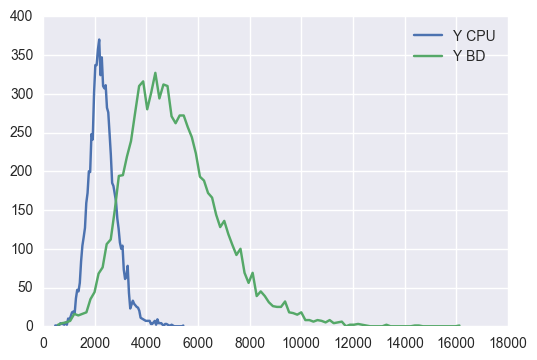

Y CPU:

Mean:			2324.27764966
Variance:		304758.662259
Standard Deviation:	552.049510695
Symmetry:		0.710104435205
Kurtosis:		1.61400137337

Y BD:

Mean:			5039.35299185
Variance:		3135127.21712
Standard Deviation:	1770.6290456
Symmetry:		0.726366906396
Kurtosis:		0.981748221161


In [22]:
import numpy as np
import pylab as p

data=Y_CPU
y,binEdges=np.histogram(data,bins=100)
bincenters = 0.5*(binEdges[1:]+binEdges[:-1])
p.plot(bincenters,y,'-', label="Y CPU")

data=Y_BD
y,binEdges=np.histogram(data,bins=100)
bincenters = 0.5*(binEdges[1:]+binEdges[:-1])
p.plot(bincenters,y,'-', label="Y BD")

p.legend(loc='upper right')

p.show()

Y_CPU2 = pd.Series(Y_CPU)

print("Y CPU:\n")
print "Mean:\t\t\t", Y_CPU2.mean()
print "Variance:\t\t", Y_CPU2.var()
print "Standard Deviation:\t", Y_CPU2.std()
print "Symmetry:\t\t", Y_CPU2.skew()
print "Kurtosis:\t\t", Y_CPU2.kurtosis()

Y_BD2 = pd.Series(Y_BD)

print
print("Y BD:\n")
print "Mean:\t\t\t", Y_BD2.mean()
print "Variance:\t\t", Y_BD2.var()
print "Standard Deviation:\t", Y_BD2.std()
print "Symmetry:\t\t", Y_BD2.skew()
print "Kurtosis:\t\t", Y_BD2.kurtosis()

Therefore we can conclude that, since kurtosis is less than 3 in both cases, they are light tailed, and we can see that they are both failry symetrical; not exactly, but enough. Another interesting fact is that while the standard deviation is roughly 23% of its mean in CPU and almost 35% in the case of DB. This shows us that the CPU variable is more consistent the than DB, which could be a relevant piece of indormation.

## Probability distribution adjustment

Due to the dificulty and lack of experience in using probability distributions in python, we decided to use XLSTAT again to fit the CPU Y and BD Y vectors.

In this section we put the values and graph we got for the following distributions:

* Exponencial
* Gamma
* Weibull 2
* Weibull 3
* Lognormal
* Pareto

In [23]:
# Pass CPU Y and BD Y to csv files to be read by excel
Y_CPU.tofile('Y_CPU.csv',sep=',',format='%10.5f')
Y_BD.tofile('Y_BD.csv',sep=',',format='%10.5f')

## For CPU
## Exponential distribution

|Statistic|	Data|	Parameters|
| ----|
|Mean	|2324.185	|2324.934|
|Variance	|304725.697	|304823.833|
|Skewness (Pearson)|0.710|	0.475|
|Kurtosis (Pearson)	|1.613	|0.338|

Kolmogorov-Smirnov test:

D: 0.028	
p-value:	< 0.0001	
alpha:	0.05

![Gamma 2 fit distribution](gamma2.png)

## Gamma 2

|Statistic|	Data|	Parameters|
| ----|
|Mean	|5039.353	|5036.048|
|Variance	|3135127.217	|3133071.032|
|Skewness (Pearson)|	0.726|	0.703|
|Kurtosis (Pearson)|	0.979|	0.741|

Kolmogorov-Smirnov test:

D: 0.008	
p-value:	0.594	
alpha:	0.05

![Gamma 2 fit distribution](gamma2.png)

## Weibull 2

|Statistic|	Data|	Parameters|
| ----|
|Mean	|2324.185|	2310.376|
|Variance|	304725.697|	379195.850|
|Skewness (Pearson)|	0.710|	-0.132|
|Kurtosis (Pearson)|	1.613|	-0.226|

Kolmogorov-Smirnov test:
D: 0.069	
p-value: < 0.0001	
alpha: 0.05

![Weibull 2 fit distribution](weibull2.png)

## Weibull 3

|Statistic|	Data|	Parameters|
| ----|
| Mean	|2324.185|	2324.185|
| Variance|	304725.697|	295057.687|
| Skewness (Pearson)|	0.710|	-0.082|
| Kurtosis (Pearson)|	1.613|	-0.255|

Kolmogorov-Smirnov test:

D: 0.059	
p-value: < 0.0001	
alpha:	0.05	

![Weibull 3 fit distribution](weibull3.png)

## Lognormal

| Statistic |	Data|	Parameters|
| ------ |
|Mean|	2324.185|	2325.697|
|Variance|	304725.697|	320582.598|
|Skewness (Pearson)	|0.710 |	0.745|
|Kurtosis (Pearson)	|1.613 |	1.002|

Kolmogorov-Smirnov test:

D: 0.036

p-value: < 0.0001

alpha: 0.05

![Lognormal fit distribution](lognormal.png)

## Pareto

|Statistic|	Data|	Parameters|
| ----|
|Mean	|2324.185	|573728884701.262|
|Variance|	304725.697	|86292.727|
|Skewness (Pearson)	|0.710|	2.000|
|Kurtosis (Pearson)	|1.613|	6.000|

Kolmogorov-Smirnov test:	
D:	0.000	
p-value:	1.000	
alpha:	0.05

This is an interesting case because the distribution is way off. So no line appears.

![Pareto fit distribution](pareto.png)

XLSTAT provided us we a very useful value for such fittings, the Kolmogorov-Smirnov test. After some investigation we discovered that this value is used to decide if a sample comes from a population with a specific distribution. This is true for continuous distributions, which we have!

For CPU the 3 best fittings where the Exponential, the Gamma 2 and the lognormal with d values 0.028, 0.008, and 0.036 respectively. We made the QQ plots for further analysis for those distributions.

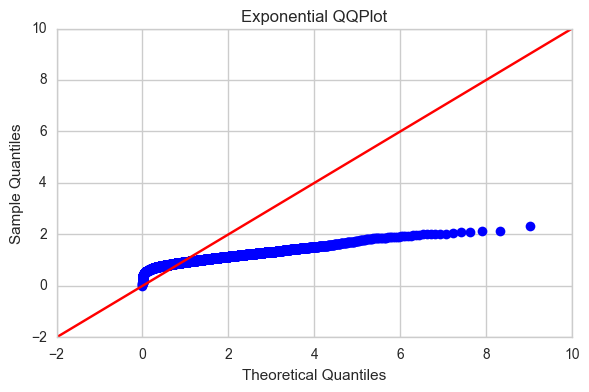

In [24]:
from scipy.stats import norm, expon, lognorm, gamma, weibull_min
import statsmodels.api as sm

with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(5, 5))
    probplot = sm.ProbPlot(Y_CPU, expon, fit=True)
    fig = probplot.qqplot(line="45")
    
    plt.title("Exponential QQPlot")
    plt.tight_layout()
    
    plt.show()

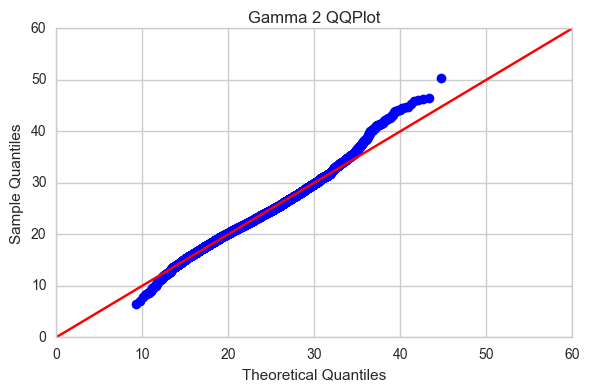

In [25]:
with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(5, 5))
    probplot = sm.ProbPlot(Y_CPU, gamma, fit=True)
    fig = probplot.qqplot(line="45")
    
    plt.title("Gamma 2 QQPlot")
    plt.tight_layout()
    
    plt.show()

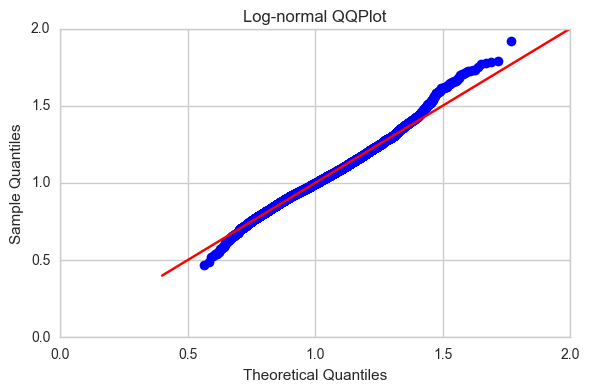

In [26]:
with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(5, 5))
    probplot = sm.ProbPlot(Y_CPU, lognorm, fit=True)
    fig = probplot.qqplot(line="45")
    
    plt.title("Log-normal QQPlot")
    plt.tight_layout()
    axes = plt.gca()
    axes.set_xlim([0,2])
    axes.set_ylim([0,2])
    
    plt.show()

It is important for the reader to note that the Pareto distribution gives the D with the lowest value. However it does not correlate visually and we belive that this comes from en error in the tools used.

##### For Database
## Log normal

|Statistic|	Data|	Parameters|
| ----|
|Mean	|5039.353|	5057.947|
|Variance	|3135127.217|	3687505.544|
|Skewness (Pearson)	|0.726|	1.194|
|Kurtosis (Pearson)	|0.979|	2.636|

Kolmogorov-Smirnov test:

D: 0.025	
p-value:	< 0.0001	
alpha:	0.05

![Log normal fit distribution](lognormaldb.png)

## Weibull 2

|Statistic|	Data|	Parameters|
| ----|
|Mean	|5039.353	|5014.704|
|Variance|	3135127.217	|3349855.894|
|Skewness (Pearson)|	0.726|	0.173|
|Kurtosis (Pearson)	|0.979|	-0.269|

Kolmogorov-Smirnov test:

D: 0.044	
p-value:	< 0.0001	
alpha:	0.05

![Weibull 2 fit distribution](weibull2db.png)

## Weibull 3

|Statistic|	Data|	Parameters|
| ----|
|Mean|	5039.353|	5039.353|
|Variance|	3135127.217	|2435772.411|
|Skewness (Pearson)|	0.726	|0.074|
|Kurtosis (Pearson)|	0.979	|-0.289|

Kolmogorov-Smirnov test:

D:	0.054	
p-value:	< 0.0001	
alpha:	0.05

![Weibull 3 fit distribution](weibull3db.png)

## Pareto

|Statistic|	Data|	Parameters|
| ----|
|Mean	|5039.353	|579254965061.702|
|Variance	|3135127.217	|156064.120|
|Skewness (Pearson)|	0.726|	2.000|
|Kurtosis (Pearson)	|0.979	|6.000|

Kolmogorov-Smirnov test:

D: 0.000	
p-value: 	1.000	
alpha:	0.05

![Pareto fit distribution](paretodb.png)

## Exponential

|Statistic|	Data|	Parameters|
| ----|
|Mean	|5117.023	|5117.023|
|Variance	|3219173.378|	0.000|
|Skewness (Pearson)	|0.756	|2.000|
|Kurtosis (Pearson)	|1.019|	6.000|

Kolmogorov-Smirnov test:

D:	0.353	
p-value:	< 0.0001	
alpha:	0.05

![Exponential fit distribution](exponentialdb.png)

## Gamma 2

|Statistic|	Data|	Parameters|
| ----|
|Mean	|5039.353|	5036.048|
|Variance|	3135127.217	|3133071.032|
|Skewness (Pearson)|	0.726|	0.703|
|Kurtosis (Pearson)	|0.979|	0.741|

Kolmogorov-Smirnov test:

D:	0.008	
p-value:	0.594	
alpha:	0.05

![Gamma 2 fit distribution](gamma2db.png)

Similarly, we can see that for the database the lognormal, weibull 2 y gamma 2 distributions offer the best fit according to the Kolmogorov-Smirnov test. The D values that correspond to each distribution are: 0.025, 0.044, 0.008.

Again we plot for these distributions with QQPlots.

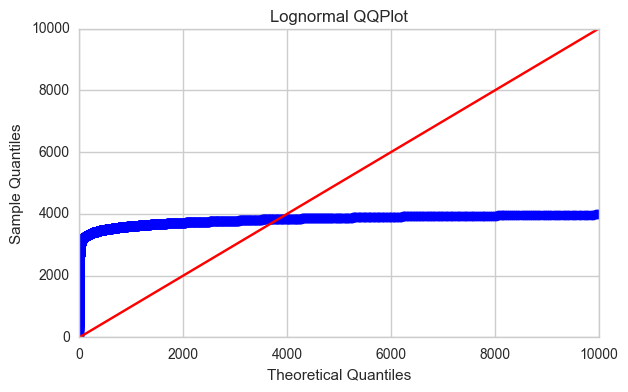

In [27]:
with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(5, 5))
    probplot = sm.ProbPlot(Y_BD, lognorm, fit=True)
    fig = probplot.qqplot(line="45")
    
    plt.title("Lognormal QQPlot")
    plt.tight_layout()
    axes = plt.gca()
    axes.set_xlim([0,10000])
    axes.set_ylim([0,10000])
    
    plt.show()

We found an outlier that greatly affects the distribution. Making this distribution infeasible for our use.

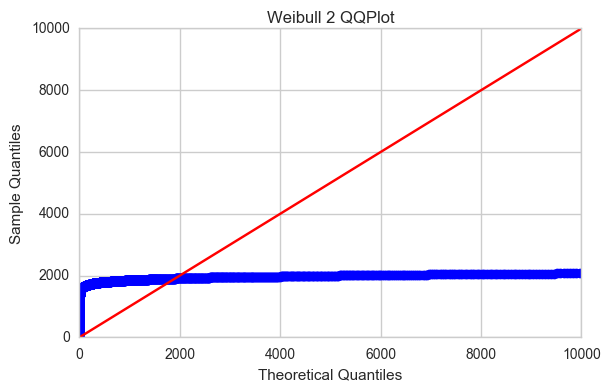

In [28]:
with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(5, 5))
    probplot = sm.ProbPlot(Y_BD, weibull_min, fit=True)
    fig = probplot.qqplot(line="45")
    
    plt.title("Weibull 2 QQPlot")
    plt.tight_layout()
    axes = plt.gca()
    axes.set_xlim([0,10000])
    axes.set_ylim([0,10000])
    
    plt.show()

Again, the outlliers in the database trace make this distribution not suited for our use.

These  results gave us confidence that our system behaves like a gamma probability distribution for both CPU and DB. Needless to say, the Pareto distribution failed returned dubious results. We conclude that we should treat these variables as gamma distribuited and base our future analysis in part B under the assumption that this is their behavior.

# Part B) Simulation

Continuing with our analysis, we wish to simulate the operation of the system and determine the load it can take with a 95% confidence level.

According to the data taken by a survey made the past 14th of november the average arrival rate was $1/\lambda=19212$
requests per hour (5.3366 requests per second). The system is composed of 6 processors with 8 cores each.

The queueing system uses a geometric distribution of p=0.5 to simulate the passing of jobs through the system.


## Queue system

For the simulation we are taking into account that the system has a sigle queue with a message feedback loop. The system is considered to have unlimited memory.

The simulation will make use of the following M/M/1 program and the feedback loop will be simulated by using the formula shown below.

<center>$serviceTime = Random(1,5)X_{CPU} + Random(1,4)BD + additionalData$</center>

where additional data is:

* Wait Time: 30 ms
* Roll-In Time: 30 ms
* Load Time: 300 ms
* Processing Time: 1200-1300 ms
* Database Time: 1200-1300 ms
* Roll-Out Time: 30 ms

In this case, we will be using the average for Database time that we had calculated in previous phases, which is 5.039. The result of the simulation is as follows:

In [29]:
import math
import random

random.seed()

class Processor:
    """
    finish_time: the time in which the processor will finish handling its current job.
    is_free: determines if the processor is free to take on a new job.
    """
    finish_time = 0
    is_free = True
    
    def __init__(self, finish_time, is_free):
        self.finish_time = finish_time
        self.is_free = is_free

def next_service_time(X):
    amount = np.random.geometric(p = 0.5)
    if amount > 4:
        amount = 4
    # 5.039
    result = (amount * X) + ((amount+1) * X)
    return result + 0.03 + 0.03 + 0.3 + 0.03

db_time = 1.5
residence_time= 6

residence_times = []
times = []

In [30]:
def find_free_processor(processors):
    """
    gets a random free processor from the available ones

    processors: all the processors in the system.
    returns: the Processor that was selected and is curently free to take a job.
    """
    free_processors = []
    
    for processor in processors:
        if processor.is_free:
            free_processors.append(processor)
            
    return free_processors[random.randint(0, len(free_processors) - 1)]

def at_least_one_free(processors):
    """
    determines if there is at least one free processor
    
    processors: processors all the processors present in the system.
    returns: true if there is at least one free processor and false otherwise.
    """
    for processor in processors:
        if processor.is_free:
            return True
    return False

def find_candidate_processor(processors, arrival_time):
    """
    finds the processor which will finish first or one of the free processors (if any)
    
    processors:  the processors present in the system
    arrival_time: the next event arrival time
    returns: the selected processor to take the new event (arrival or departure)
    """
    result = processors[0]
    
    for processor in processors:
        if processor.finish_time < result.finish_time:
            result = processor
            
    if result.finish_time > arrival_time and at_least_one_free(processors):
        return find_free_processor(processors)
    
    return result

In [31]:
# Global variables for the simulation
processors = []
num_processors = 48
total_observation_time = 5000 # cambiar
current_time = 0
arrival_time = 0
num_jobs = 0
max_jobs = 999999 # cambiar
interarrival_time = 1 / 5.3366 # cambiar (JUGAR)
last_event = 0
time_diff = 0
S = 0
expected_service_time = 2.6 # cambiar
busy_time = 0
completed_jobs = 0
num_rejected_jobs = 0
total_jobs = 0

# initialize processors to free
for i in xrange(0,num_processors):
    processors.append(Processor(999999, True))
    
while current_time < total_observation_time:
    processor = find_candidate_processor(processors, arrival_time)
    
    # it can be free or occupied
    if arrival_time <= processor.finish_time:
        if num_jobs < max_jobs:
            current_time = arrival_time
            num_jobs += 1
            time_diff = current_time - last_event
            S += (num_jobs - 1) * time_diff
            last_event = current_time
            
            arrival_time = current_time - (interarrival_time * math.log(random.random()))
            
            if num_jobs <= len(processors):
                service_time = next_service_time(5.039)
                processor.finish_time = current_time + service_time
                busy_time += min(service_time, total_observation_time - current_time)
                processor.is_free = False
        else:
            arrival_time = current_time - (interarrival_time * math.log(random.random()))
            num_rejected_jobs += 1
    else:
        # there has been a departure from the system
        current_time = processor.finish_time
        num_jobs -= 1
        completed_jobs += 1
        time_diff = current_time - last_event
        S += (num_jobs + 1) * time_diff
        last_event = current_time

        if num_jobs >= len(processors):
            service_time = next_service_time(5.039)
            processor.finish_time = current_time + service_time
            busy_time += min(service_time, total_observation_time - current_time)
            processor.is_free = False
        else:
            processor.is_free = True
            processor.finish_time = 999999

In [32]:
print "N: {0}".format(S/current_time)
print "U: {0}".format(busy_time/(current_time * len(processors)))
print "R: {0}".format(S/completed_jobs)
print "X: {0}".format(completed_jobs/current_time)

N: 8512.04332114
U: 0.998961017285
R: 4306.86930695
X: 1.97638765296


Note that the values are very high. If we had used the average that came with the definition of the problem (1.25), the results would be the following:

N: 33.9622966712

U: 0.707036511606

R: 6.32857482319

X: 5.36649998145

This makes sense, since the average time for DB is ambout 4 times smaller that the one we calculated. Now, we will evaluate, through simulations, how much time reduction is needed to make the system faster. Since N in the simulations with the data provided to us (not the one we calculated, which was way bigger) is less than 48, which is the amount of processors, it can be assumed that there are no jobs on queue. Thus, the solution to making the system faster is not to increase processors or interarrival time, but to decrease the service time, by decreasing either CPU or DB speed. We will approach this by multiplying the average time in DB and CPU by 0.95 on each iteration.

In [33]:
def next_service_time(X):
    amount = np.random.geometric(p = 0.5)
    if amount > 4:
        amount = 4
    # 5.039
    result = (amount * X) + ((amount+1) * X)
    return result + 0.03 + 0.03 + 0.3 + 0.03

db_time = 1.5
residence_time= 6

residence_times = []
times = []

while residence_time > 5:

    # Global variables for the simulation
    processors = []
    num_processors = 48
    total_observation_time = 5000 # cambiar
    current_time = 0
    arrival_time = 0
    num_jobs = 0
    max_jobs = 999999 # cambiar
    last_event = 0
    time_diff = 0
    S = 0
    expected_service_time = 2.6 # cambiar
    busy_time = 0
    completed_jobs = 0
    num_rejected_jobs = 0
    total_jobs = 0

    # initialize processors to free
    for i in xrange(0,num_processors):
        processors.append(Processor(999999, True))

    while current_time < total_observation_time:
        processor = find_candidate_processor(processors, arrival_time)

        # it can be free or occupied
        if arrival_time <= processor.finish_time:
            if num_jobs < max_jobs:
                current_time = arrival_time
                num_jobs += 1
                time_diff = current_time - last_event
                S += (num_jobs - 1) * time_diff
                last_event = current_time

                arrival_time = current_time - (interarrival_time * math.log(random.random()))

                if num_jobs <= len(processors):
                    service_time = next_service_time(db_time)
                    processor.finish_time = current_time + service_time
                    busy_time += min(service_time, total_observation_time - current_time)
                    processor.is_free = False
            else:
                arrival_time = current_time - (interarrival_time * math.log(random.random()))
                num_rejected_jobs += 1
        else:
            # there has been a departure from the system
            current_time = processor.finish_time
            num_jobs -= 1
            completed_jobs += 1
            time_diff = current_time - last_event
            S += (num_jobs + 1) * time_diff
            last_event = current_time

            if num_jobs >= len(processors):
                service_time = next_service_time(db_time)
                processor.finish_time = current_time + service_time
                busy_time += min(service_time, total_observation_time - current_time)
                processor.is_free = False
            else:
                processor.is_free = True
                processor.finish_time = 999999
    residence_time = S/completed_jobs
    print "DB and CPU Time: {0}".format(db_time)
    print "N: {0}".format(S/current_time)
    print "U: {0}".format(busy_time/(current_time * len(processors)))
    print "R: {0}".format(S/completed_jobs)
    print "X: {0}".format(completed_jobs/current_time)
    print ""
    
    residence_times.insert(0, S/completed_jobs)
    times.insert(0, db_time)
    
    db_time = db_time * 0.95

DB and CPU Time: 1.5
N: 40.2882374109
U: 0.829615654989
R: 7.5755795563
X: 5.31817230767

DB and CPU Time: 1.425
N: 38.7203974338
U: 0.801069862649
R: 7.21131115358
X: 5.36939768777

DB and CPU Time: 1.35375
N: 36.9901297799
U: 0.767474918123
R: 6.87268814667
X: 5.38219238098

DB and CPU Time: 1.2860625
N: 34.5506961127
U: 0.719105865104
R: 6.51408445556
X: 5.30399879651

DB and CPU Time: 1.221759375
N: 32.8803626053
U: 0.684503586881
R: 6.18825975227
X: 5.31334558043

DB and CPU Time: 1.16067140625
N: 31.5402943285
U: 0.65696318716
R: 5.91338856454
X: 5.33370908815

DB and CPU Time: 1.10263783594
N: 30.0779557616
U: 0.626562534778
R: 5.62900404071
X: 5.34338855401

DB and CPU Time: 1.04750594414
N: 28.7158623275
U: 0.598232059907
R: 5.34916551525
X: 5.36828823965

DB and CPU Time: 0.995130646934
N: 27.5350200838
U: 0.573635834864
R: 5.12382775105
X: 5.37391602951

DB and CPU Time: 0.945374114587
N: 26.2179082087
U: 0.546204985684
R: 4.88211636506
X: 5.3701932212



We can conclude from our results that the response time for the database and CPU systems should decrease considerably to achieve the desired system behavior. This can be seen in the plot below:

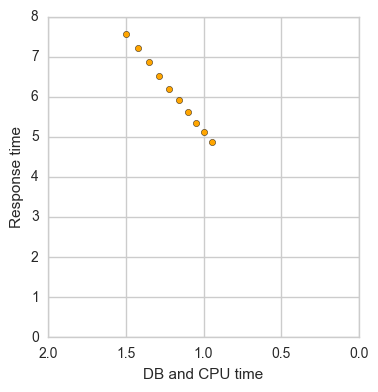

In [34]:
with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(4, 4))
    
    plt.scatter(times, residence_times, c="Orange")
    plt.ylabel('Response time')
    plt.xlabel('DB and CPU time')
    plt.tight_layout()
    axes = plt.gca()
    axes.set_xlim([2,0])
    axes.set_ylim([0,8])
    
    plt.tight_layout
    plt.show()

This clearly shows that better equipment for both database access and CPU processor speed is needed. However, we must take into account that the number of processors of the server system should remain as 48 to achive optimal response times. 

Therefore, the problem resides not in the interarrival time, but the service time; from the point in time we began to the optimal value obtained, the number in jobs in system never was above 48.

Now we wish to visualize the behavior of the system while varying the interarrival time:

In [35]:
lambda_modifiers = np.arange(1,3,0.1)
lambdas = []
for value in lambda_modifiers:
    lambdas.append(1 / (value * 5.3366))
lambdas

wait_time_arr = []

# Global variables for the simulation
def vary_interarrival_time(new_time):
    db_time = 0.945374
    residence_time= 6
    processors = []
    num_processors = 48
    total_observation_time = 5000 # cambiar
    current_time = 0
    arrival_time = 0
    num_jobs = 0
    max_jobs = 999999 # cambiar
    interarrival_time = new_time # cambiar (JUGAR)
    last_event = 0
    time_diff = 0
    S = 0
    expected_service_time = 2.6 # cambiar
    busy_time = 0
    completed_jobs = 0
    num_rejected_jobs = 0
    total_jobs = 0

    # initialize processors to free
    for i in xrange(0,num_processors):
        processors.append(Processor(999999, True))
    
    while current_time < total_observation_time:
        # Global variables for the simulation
        processor = find_candidate_processor(processors, arrival_time)

        # it can be free or occupied
        if arrival_time <= processor.finish_time:
            if num_jobs < max_jobs:
                current_time = arrival_time
                num_jobs += 1
                time_diff = current_time - last_event
                S += (num_jobs - 1) * time_diff
                last_event = current_time

                arrival_time = current_time - (interarrival_time * math.log(random.random()))

                if num_jobs <= len(processors):
                    service_time = next_service_time(db_time)
                    processor.finish_time = current_time + service_time
                    busy_time += min(service_time, total_observation_time - current_time)
                    processor.is_free = False
                    wait_time_arr.append(processor.finish_time - current_time)
            else:
                arrival_time = current_time - (interarrival_time * math.log(random.random()))
                num_rejected_jobs += 1
        else:
            # there has been a departure from the system
            current_time = processor.finish_time
            num_jobs -= 1
            completed_jobs += 1
            time_diff = current_time - last_event
            S += (num_jobs + 1) * time_diff
            last_event = current_time

            if num_jobs >= len(processors):
                service_time = next_service_time(db_time)
                processor.finish_time = current_time + service_time
                busy_time += min(service_time, total_observation_time - current_time)
                processor.is_free = False
            else:
                processor.is_free = True
                processor.finish_time = 999999
                
    residence_time = S/completed_jobs
    db_time = db_time * 0.95
    
    wait = np.array(wait_time_arr)
    
    successes = 0.0
    for value in wait:
        if(value <= 5):
            successes += 1
    
    # N, U, R, X
    return (S/current_time, busy_time/(current_time * len(processors)), 
            S/completed_jobs, completed_jobs/current_time, successes / len(wait))

In this section, we populate our results in a table which we will use to plot the data for later analysis. It is worth noting that based on our prevous results, the database and CPU service time should have to be reduced to, more or less, 0.945374114587 seconds. We consider this our normal value of operation which we will increase to three times according to the specificaction.

In [36]:
df = pd.DataFrame()
result = []

for value in lambdas:
    result.append(vary_interarrival_time(value))

df['Interarrival time'] = lambdas

column_values = []
for value in result:
    column_values.append(value[0])
    
df['N'] = column_values

column_values = []
for value in result:
    column_values.append(value[1])

df['U'] = column_values

column_values = []
for value in result:
    column_values.append(value[2])

df['R'] = column_values

column_values = []
for value in lambdas:
    column_values.append(value ** -1)

df['X'] = column_values

print df

    Interarrival time             N         U            R         X
0            0.187385     25.822540  0.537959     4.872668   5.33660
1            0.170350     28.759445  0.599150     4.857530   5.87026
2            0.156154     31.149868  0.648889     4.893325   6.40392
3            0.144142     33.473649  0.696768     4.897268   6.93758
4            0.133847     36.679227  0.762303     4.895327   7.47124
5            0.124923     39.305615  0.812105     4.915820   8.00490
6            0.117116     42.708895  0.867042     5.019553   8.53856
7            0.110227     47.623854  0.924327     5.266984   9.07222
8            0.104103     58.802819  0.969912     6.150827   9.60588
9            0.098624    917.401355  0.999538    93.126316  10.13954
10           0.093693   2194.952191  0.999501   223.916773  10.67320
11           0.089231   3377.879582  0.999479   344.605015  11.20686
12           0.085175   4898.827070  0.999565   499.188868  11.74052
13           0.081472   6134.33805

<center>Table 2.1</center>

The table shows that we are able to sustain with our optimal CPU and DB processors interarrival times between 0.187385 and 0.110227 without falling into queueing necesities. This range also gives residence times below 5 in average and good throughputs between 5 and 9 jobs per second. Above these values, the cost for memory increases exponentially, so it is not feasible to spend in this area. We will plot the previous table below for better visualization:

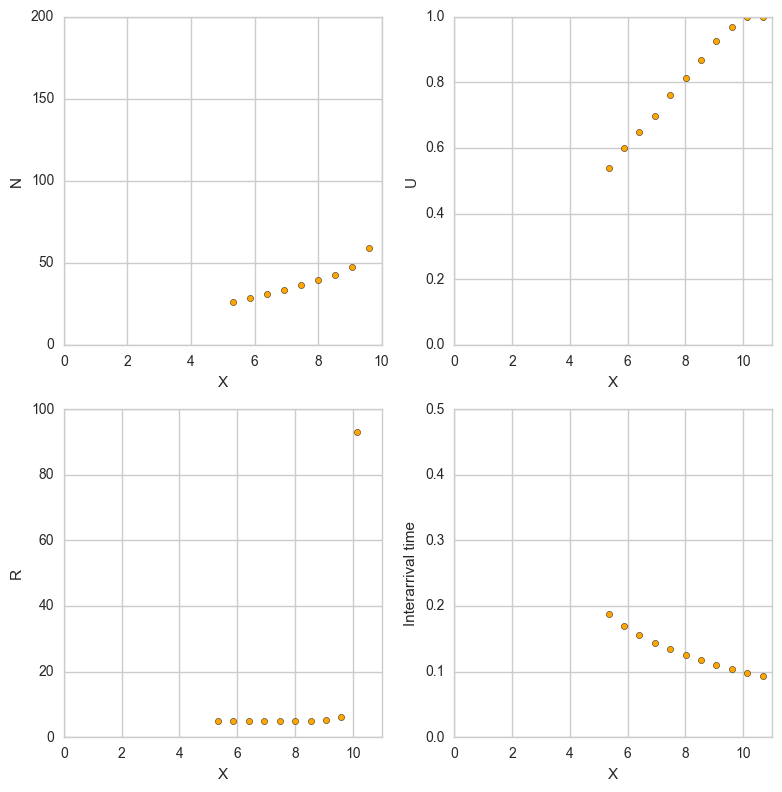

In [37]:
with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(8, 8))
    plt.subplot(221)

    plt.scatter(df['X'], df['N'], c="Orange")
    plt.ylabel('N')
    plt.xlabel('X')
    plt.tight_layout()
    axes = plt.gca()
    axes.set_xlim([0,10])
    axes.set_ylim([0,200])
    
    plt.subplot(222)
    plt.scatter(df['X'], df['U'], c="Orange")
    plt.ylabel('U')
    plt.xlabel('X')
    plt.tight_layout()
    axes = plt.gca()
    axes.set_xlim([0,11])
    axes.set_ylim([0,1])
    
    plt.subplot(223)
    plt.scatter(df['X'], df['R'], c="Orange")
    plt.ylabel('R')
    plt.xlabel('X')
    plt.tight_layout()
    axes = plt.gca()
    axes.set_xlim([0,11])
    axes.set_ylim([0,100])
    
    plt.subplot(224)
    plt.scatter(df['X'], df['Interarrival time'], c="Orange")
    plt.ylabel('Interarrival time')
    plt.xlabel('X')
    plt.tight_layout()
    axes = plt.gca()
    axes.set_xlim([0,11])
    axes.set_ylim([0,0.5])
    
    plt.tight_layout
    plt.show()

Therefore as the arrival rate decreases a clear change in NUR is seen. Utilization increases linearly and at 10 jobs per second is very close to one. Similarly, the residence time increases exponentially once 10 jobs per second is reached but remains fairly constant below this threshold.

The number of jobs in the system follows a similar pattern but has a higher steep than the residence time. As long as we don't go above a throughput of 10 jobs per second, the system will be mainly stable and won't have an exponential behavior.

In [38]:
for value in result:
    print value[4]

0.502508392743
0.502476041184
0.500278640236
0.500024659291
0.499949222469
0.500064718887
0.500064205031
0.499507023419
0.499693308798
0.499659090476
0.499628717113
0.499634511273
0.499644111859
0.49964421478
0.499659497731
0.499682392365
0.499661553205
0.49966162269
0.499642677939
0.499642743125


Sadly we could not achieve these optimal values with a confidence of 95% but that of 50%. The max value gave us 8 on some instances, and the min 3 in others, so we consider this a good result. We belive that the improvement in CPU and DB time, is feasible and could be afforded by the institution, interarrival times also remain feasible. 

# Part C) Modeling

We wish to determine to which queueing model our simulation adheres to best. To do this we divided our analysis into two parts, the first will prove if our simulation correlates to what the Operational Laws dictate as the expected behavior of the system. The second one will use different modeling formulas. The ones we selected to try out were:

* Markovian Chains
    * M/M/1
    * M/M/k
    
For each one of these models, we will find NURX and compare them.

## Operational Laws

Based on the project specifications, we have several values to consider. These values are:

<center>$\lambda = 5.3366 \frac{requests}{second}$</center>
<center>$serviceConstants = 0.39$</center>

Based on our previous analysis, we determined that our optimal CPU and DB services times should be reduced to 0.94 seconds per request. These are the values used in our simulation, so these are the ones that will be used here.

We will start by finding the residence time $R$ which is equal to $S$.

<center>$E[S] = serviceConstants + E[t_{cpu}] \cdot E[g + 1] + E[t_{db}] \cdot E[g]$</center>

Therefore we pass to find the expected value for g which follows a geometric distribution. Our simulation, took into account at least one access to the Database, so it was relatively easy to model as seen in the course since it maps directly to an exponential distribution. It is also worth noting that the summatory is truncated at the value of 4, because that is the constraint of the system based on its specification.

<center>$E[g] = \sum_{k=1}^{4} k  \cdot P[k] + \sum_{k=5}^{\infty} 4 \cdot P[k]$</center>

To simpify such procedure we solve for the first term manually according to the following possible probability values in the summatory. The full process of derivation to get the concrete value is demonstrated below:

1. $P(1)$
2. $P(2)$
3. $P(3)$
4. $P(4)$

where $P(X)$ being  geometric is equal to $p \cdot (1-p)^{X-1}$. 

$firstTerm = \sum_{k=1}^{4} k\cdot P[k]$

$fristTerm = \sum_{k=1}^{4} k\cdot p(1-p)^k$

$firstTerm = [1\cdot P(1) + 2\cdot P(2) + 3\cdot P(3) + 4\cdot P(4)]$

Evaluating each P(X) with its corresponding value, we obtain:

$firstTerm = 0.5 + 0.5 + 0.375 + .25= 1.625$

We use the summatory substitutions to get a closed formula for the second term:

$secondTerm = \sum_{k=5}^{\infty} 4 \cdot P[k]$

$secondTerm = \sum_{k=5}^{\infty} 4 \cdot p(1-p)^k$

$secondTerm = 4p\cdot\sum_{k=5}^{\infty} a^k$

$secondTerm = 4p\cdot\sum_{j=0}^{\infty} a^{j+5}$

$secondTerm = 4pa^5(\frac{1}{1 - a})$

$secondTerm = 4p(1-p)^5(\frac{1}{1 - (1-p)})$

$secondTerm = 4(1-p)^5$

Therefore,

$E[g] = 3.0625 + 4(1-p)^5 = 1.625 + 0.125 = 1.75$

With the value of $E[g]$, we used on of the statistical moments law to calculate $E[g+1]$ which is simply their sum. Therefore,

$E[g+1] = E[g] + 1 = 1.75 + 1 = 2.75$

With the previous values calculated, we can get the expected service time of the system, which is:

$E[S] = 0.39 + 0.94 \cdot 2.75 + 0.94 \cdot 1.75 = 4.62$</center>

We proceed to find NURX from here:

$R = S = 4.62 seconds$

$X = \lambda = 5.3366 \frac{requests}{second}$

$U = \frac{S \cdot X}{P} = \frac{4.62 \cdot 5.3366}{48} = 0.5136$

$N = R \cdot X = 4.62 \cdot 5.3366 = 24.65 = 25$

Which give very close results to those given by our simulation in normal conditions (See table 2.1, first row to make the comparison). This proves that, based on our assumptions, our simulation is given the correct results.

## Queuing Theory Modeling

Being this an M/M/k model, we wish to compare it to other queueing models seen in the course. Explicitly, we wish to see how well the system behaves if it was implemented in such models. To make such comparison easier to grasp and analyze, we will find NURX($L \rho W \lambda$) for each one and do the comparison from there.

### M/M/1 Queue model

First, we wish to try out the Markovian queue if the system had a single server. The equations used to find NURX are the ones seen in the course and therefore won't be demonstrated here.

Since the arrival rate $\lambda$ is greater than the service rate $\mu$, the system would start growing the job queue indefinitely, therefore it cannot be modeled as an M/M/1 queue. As prove of it, if we try to get the utilization of the system $\rho$, it is greater than one and a system's utilization can never be greater or equal to one.

The formulas that would have been used are:

<center>$\rho = \frac{\lambda}{\mu}$</center>

<center>$L = \frac{\rho}{1 - \rho}$</center>

<center>$W = \frac{L}{\lambda}$</center>

### M/M/1/M Queue model

Even though we know that the system is not stable when only one processor is present, we wish to model it using a limited queue size of 30 requests and only one processor. Even though the original system has the property of having an unlimited queue, we belive it will be interesting to see how the system behaves under such model and conditions.

Since this model was also seen in the course, the equations to find NURX or $L \rho W \lambda$ won't be derived.

<center>$\rho = \frac{\lambda}{\mu} = \frac{5.3366}{0.216} = 24.65$</center>

<center>$P_0 = \frac{1 - \rho}{1-\rho^{M+1}} = \frac{-23.65}{-1.4 \times 10^{43}} \approx 0$</center>

<center>$U = 1 - P_0 \approx 1 - 0 \approx 1$</center>

<center>$L = \frac{\rho}{1 - \rho} - \frac{(M + 1)\rho^{M+1}}{1-\rho^{M+1}} = 
\frac{24.65}{1 - 24.65} - \frac{(31)24.65^{31}}{1-24.65^{31}} = -1.042 + 31 = 29.95 \quad requests$</center>

<center>$\lambda_{efective} = \mu \cdot (1 - P_0) = 0.216 * (1 - 0) \approx 0.216$</center>

<center>$W = \frac{L}{\lambda_{efective}} = \frac{29.95}{0.216} = 138.65 \quad seconds$</center>

So, the results show that each job (that is not rejected) will have a residence time of 138.65 seconds, that the queue will always be full and that utilization will be close very close to 1. A clear outcome from a system that is not stable and has an arrival rate which is greater than its service rate.

### M/M/c

Based on the contents of the book titled <i>Queuing Formulas</i> found at this [link](http://web.mst.edu/~gosavia/queuing_formulas.pdf) and the GitHub article found [here](http://robharrop.github.io/maths/performance/2016/03/07/multi-server-queues.html), we can find the probability of the system being empty:

<center>$P_0 = \frac{1}{\sum_{m=0}^{c-1} \frac{\rho^m}{m!} + (\frac{\rho^c}{c!})(\frac{1}{1-\frac{\rho}{c}})}$</center>

Evaluating the previous equations with our real values and being c, our number of servers, 48 we get:

<center>$P_0 = \frac{1}{\sum_{m=0}^{47}\frac{24.65^m}{m!}+(\frac{24.65^{48}}{48!})(\frac{1}{1-\frac{24.65}{48}})} 
= 1.96 \times 10^{-11}$</center>

which is logical, since the arrival rate is by far greater than the service rate, so it will almost always be busy. Now let's find the wait time for a job that enters the system ($W$):

<center>$W_q = \frac{P_c}{\mu(N-A)}$</center>

To find $P_c$ we require Erlang’s C Formula  which value is calculated via:

<center>$C(c, \rho) = \frac{\frac{\rho^c}{c!}\frac{c}{c-\rho}}{\sum_{m=0}^{c-1}\frac{\rho^m}{m!} + \frac{\rho^c c}{c!(1-\rho)}}$</center>

where $c$ is the number of servers. Making some substitutions and a bit of algebra (explained in more detail [here](https://dspace.vsb.cz/bitstream/handle/10084/84489/AEEE-2011-9-1-7-chromy.pdf?sequence=1)) we find that $C(c, \rho)$ can be transformed to find $P_n$ which is obtained via:

<center>$P_c(N, \eta) = \frac{\frac{(N\eta)^N}{N!(1-\eta)}}{\sum^{N-1}_{i=0}\frac{(N\eta)^i}{i!}+\frac{(N\eta)^N}{N!(1-\eta)}}$</center>

where $N$ is the number of servers (48) and $\eta$ is the load or utilization of the system. The utilization can be obtained using the following formula:

<center>$\eta = \frac{\lambda}{N\mu} = \frac{5.3366}{48*0.216} = 0.5147$</center>

We can now start getting concrete values:

<center>$P_c(48, 0.5147) = \frac{\frac{(48(0.5147))^{48}}{48!(1-0.5147)}}{\sum^{47}_{i=0}\frac{(48(0.5147))^i}{i!}+\frac{(48(0.5147))^{48}}{48!(1-0.5147)}} = 2.2137 \times 10^{-5}$</center>

<center>$W_q = \frac{2.2137 \times 10^{-5}}{0.216(48-24.65)} = 4.3892 \times 10^{-6} \quad seconds$</center>

<center>$W = \frac{1}{0.216} + 4.3892 \times 10^{-6} = 4.63 \quad seconds$</center>

which makes sense since no queue is being used because according to the operational laws, all jobs are processed by a server at a given time. Lets calculate the last value $L$ and see if it behaves like our simulation:

<center>$L = \lambda W = 5.3366(4.63) = 24.7 \quad jobs$</center>

So, as expected it behaves very similarly to our real model in all aspects.

### M/G/k

We decided to move away from the Markovian models and look at more general ones, we tried out first the M/G/k queue. This model uses the M/M/c model to derive the expected residence time $W$ via Kingman's law of congestion.

We must consider that this is just an approximation, so for this model del total waiting time $W$ is:

<center>$W^{M/G/k} \approx W^{M/M/c}\frac{C^2_\lambda+C^2_s}{2}$</center>

it is worth noting that $C^{2}_{X}$ is the squared coefficient of a variation of a positive random variable, and that $S$ is the service time of the system. Given that $\mu$ and $\lambda$ are exponentially distribuited, their values are:

<center>$C^{2}_{\lambda} = \frac{Var[\lambda]}{E[\lambda]^2} = \frac{\frac{1}{\lambda^2}}{(\frac{1}{\lambda})^2} = 1$</center>

<center>$C^{2}_{\mu} = \frac{Var[\mu]}{E[\mu]^2} = \frac{\frac{1}{\mu^2}}{(\frac{1}{\mu})^2} = 1$</center>

<center>$W^{M/G/k} \approx 4.63 \frac{1 + 1}{2} \approx 4.63 \quad seconds$</center>

Therefore, when the arrival and service rates are exponentially distribuited, the values for the wait time between the M/G/k and M/M/c models are practically the same. As a result, $\rho$ and $L$ will be as well, similar, to the M/M/c values.

### Results comparison
 The models that were most similar to our results in the simulation were M/M/c and M/G/k, while the other two models discussed were not similar at all. In a way, these results are obvious, since the other two models consider only one processor, and our system had 48. Having said that, here is a graph comparing the values gotten for each model and the simulation.   

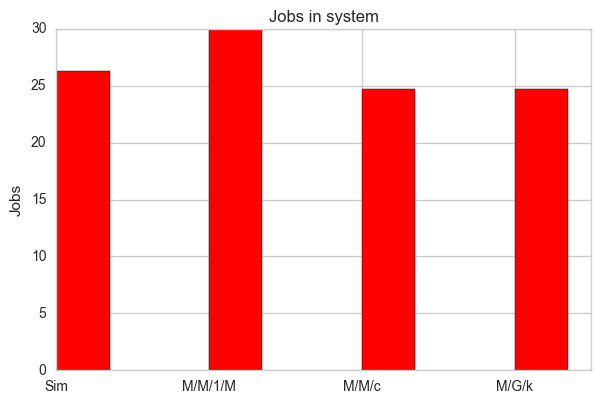

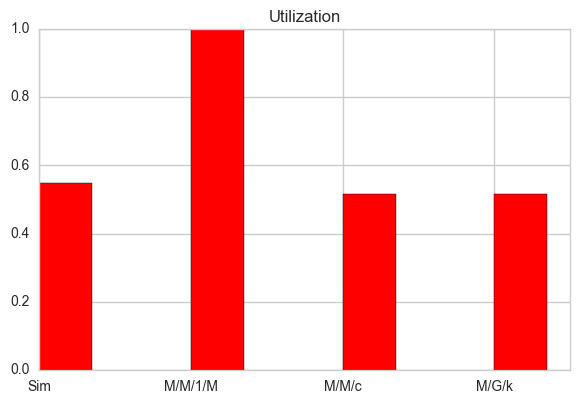

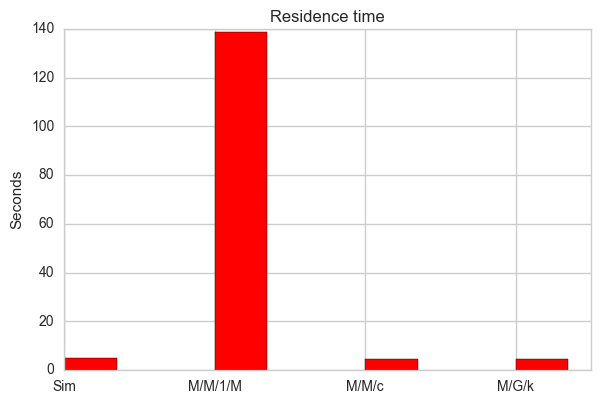

In [39]:
with plt.style.context('seaborn-whitegrid'):
    f, ax = plt.subplots()
    n_values = (26.260786, 29.95, 24.7,24.7)
    ind = np.arange(4)  # the x locations for the groups
    width = 0.35       # the width of the bars
    rects1 = ax.bar(ind, n_values, width, color='r')
    
    plt.tight_layout()
    
    # add some text for labels, title and axes ticks
    ax.set_title('Jobs in system')
    ax.set_xticks(ind)
    ax.set_xticklabels(('Sim', 'M/M/1/M', 'M/M/c', 'M/G/k'))
    ax.set_ylabel('Jobs')
    plt.show()
    

    f, ax = plt.subplots()
    n_values = (0.547085, 1, .5147,.5147)
    ind = np.arange(4)  # the x locations for the groups
    width = 0.35       # the width of the bars
    rects1 = ax.bar(ind, n_values, width, color='r')
    
    plt.tight_layout()
    
    # add some text for labels, title and axes ticks
    ax.set_title('Utilization')
    ax.set_xticks(ind)
    ax.set_xticklabels(('Sim', 'M/M/1/M', 'M/M/c', 'M/G/k'))
    plt.show()
    
    f, ax = plt.subplots()
    n_values = (4.8775, 138.65, 4.63,4.63)
    ind = np.arange(4)  # the x locations for the groups
    width = 0.35       # the width of the bars
    rects1 = ax.bar(ind, n_values, width, color='r')
    
    plt.tight_layout()
    
    # add some text for labels, title and axes ticks
    ax.set_title('Residence time')
    ax.set_xticks(ind)
    ax.set_xticklabels(('Sim', 'M/M/1/M', 'M/M/c', 'M/G/k'))
    ax.set_ylabel('Seconds')
    plt.show()

    
    plt.tight_layout
    plt.show()

As it can be seen, both the M/M/c and M/G/k model have very similar results to the simulation.

# Conclusions

Analysis and simulation have a big impact in the industry and the world. These let us save money in complex cases by letting us understand how something is related to something else and predict how a process will behave. In this project, we had to analyze which component or components were influencing the most a SAP system, specifically regarding response time so we could bring a proposal of how improve it. We found that CPU and DB service times were the most influential. Therefore, to achieve a lower response time we had to invest in CPU processors and DB disks. As previously mentioned, this make companies save money because once you know the root of the problem you don’t have to spend money in other components that won’t impact as much in the response time. Thus, the less electronic components we consume the less we damage the environment.

E-waste are the circuits and electronic components that we no longer use. At the end of their lifecycle they generally end in the trash. E-waste affects heavily the environment and lately, researchers have not only linked it to environment degradation, but also to adverse effects on human health.

Computers are the biggest e-waste source. They compound around the 74% of the number of electronics wasted and Mexico has a significant impact in the generation of e-waste in the world. As we can see they wasted 1.138 millions of tons in the 2012, almost the same number as Russia.

![g1](g1.png)

Nonetheless, with the pass of the time, it is more often practice to recycle in companies. This can be seen in the chart shown below:

![g2](g2.png)

We as consumers must be careful with how much we consume. If we take care of the environment we implicitly act in an ethical manner. Currently we are college students, but in some years, we will have our own families. As a result, we have a responsibility to teach them what affects other humans and the world so they can think more ethically before acting. By teaching them ethics and environmental cares we are surely going to make a great impact in the future.

E-waste is a real thing, and we must fight it.

# References

1. IOP (Institute of Physics). 2011. E-waste pollution’ threat to human health. [source](http://www.iop.org/news/11/may/page_51103.html)

2. Livescience. 2013. World's E-Waste to Grow 33% by 2017, Says Global Report. [source](http://www.livescience.com/41967-world-e-waste-to-grow-33-percent-2017.html)

3. Electronics TakeBack Coalition. E-Waste In Landfills. [source](http://www.electronicstakeback.com/designed-for-the-dump/e-waste-in-landfills/)